In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/netflix-shows/netflix_titles.csv


# 1. Data Loading and Pre-processing

In [2]:
data = pd.read_csv('/kaggle/input/netflix-shows/netflix_titles.csv')
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [3]:
# Data Information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [4]:
# Checking for Missing Data

print('Frequency of Missing Data in respective columns \n \n {}'.format(data.isna().sum()))

Frequency of Missing Data in respective columns 
 
 show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64


In [5]:
# Checking and Dropping duplicate entries if exists
new_data = data.drop_duplicates('title')

print('Data before duplicate removal: {}'.format(data.shape))
print('Data after duplicate removal: {}'.format(new_data.shape))

Data before duplicate removal: (7787, 12)
Data after duplicate removal: (7787, 12)


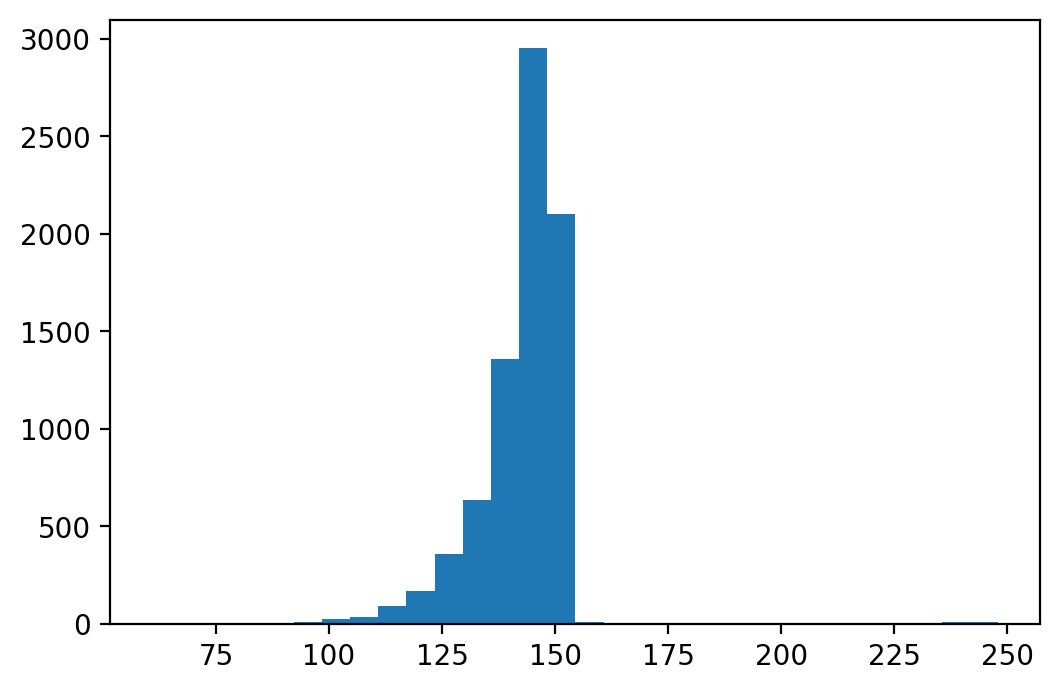

In [6]:
# Checking the distribution for length of description

desc_length = data['description'].apply(lambda x: len(x))
fig, ax = plt.subplots(1,1, dpi=200)
ax.hist(desc_length, bins=30)
plt.show()

For clustering purposes, I will be focusing on 'description' columns as it consists of description of various movies which could be used to cluster them.

# Clustering by DEC

**Reference:** https://arxiv.org/pdf/1511.06335.pdf

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler

from time import time
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input, Embedding
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [8]:
token_data = data.description
maxlen = 1500 # Max number of frequently occuring words
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(token_data)
seq = tokenizer.texts_to_sequences(token_data)
word_index = tokenizer.word_index
seq_data = pad_sequences(seq, maxlen=maxlen)

In [9]:
# Scaling of Data
scaler = MinMaxScaler()
seq_data = scaler.fit_transform(seq_data)

In [10]:
# AutoEncoder Architecture of DEC Module

def autoencoder(size, activation_fn='relu'):
    """
    This function creates the autoencoder model of the DEC module on the basis of 
    following input parameters
    
    ------------------
    Parameters
    ------------------
    
    size: List of no. of neurons for each layer in  deep encoder
    activation_fn: type of activation function to be used
    
    ------------------
    Returns
    ------------------
    (autoencoder, encoder): Autoencoder and Encoder model
    """
    
    n_layers = len(size) - 1
    
    # --------------------------
    # Encoder
    #---------------------------
    
    # Input Layer
    input_data = Input(shape = (size[0], ), name='input')
    x = input_data
    
    # Hidden Layers
    for n in range(n_layers - 1):
        x = Dense(size[n+1], kernel_initializer = 'glorot_uniform', activation = activation_fn, name='encoder_layer_{}'.format(n))(x)
        
    # Latent Layer
    encoder_out = Dense(size[-1], name='Latent_layer')(x)
    
    x = encoder_out # Input for Decoder
    
    # --------------------------
    # Decoder
    #---------------------------
    
    # Hidden Layers
    for n in range(n_layers - 1, 0, -1):
        x = Dense(size[n], activation = activation_fn, kernel_initializer = 'glorot_uniform', name = 'decoder_layer_{}'.format(n))(x)
        
    # Decoder Output
    decoder_out = Dense(size[0], kernel_initializer = 'glorot_uniform')(x)
    
    autoencoder_model = Model(inputs = input_data, outputs = decoder_out, name = 'autoencoder')
    encoder_model = Model(inputs = input_data, outputs = encoder_out, name = 'encoder')
    
    return autoencoder_model, encoder_model

In [27]:
n_clusters = 20 # Initial Cluster Choice
n_epochs   = 50 
batch_size = 128

In [28]:
size = [seq_data.shape[-1], 600, 600, 1200, 20]
optimizer = 'rmsprop'
epochs = n_epochs

In [13]:
# Clustering Layer of the DEC Module
# Reference: https://faroit.com/keras-docs/1.2.2/layers/writing-your-own-keras-layers/

class ClusteringLayer(Layer):
    """
    This class defines the clustering layer that converts the input_sample to 
    softlabels i.e. a vector which represents the probability of a sample belonging to each cluster.
    """
    
    def __init__(self, n_clusters, weights = None, alpha = 1.0, **kwargs):
        
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)
        
    def build(self, input_shape):
        # Creating weight variable for this domain
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform') 
        
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
            
        self.built = True
        
    def call(self, inputs, **kwargs):
        """
        Implementation of student's t-distribution which measures the similarity between embedded_points and centroid
        
        ---------------
        Parameters
        ---------------
        inputs: the variable containing data
        
        
        ---------------
        Return
        ---------------
        student's t-distribution of each sample
        
        """
        
        # Reference: https://arxiv.org/pdf/1511.06335.pdf
        
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        
        return q

In [14]:
# Some parameters for clustering Algorithm
loss = 0
index = 0
maxiter = 1000 # 8000
update_interval = 100 # 140
index_array = np.arange(seq_data.shape[0])

In [38]:
class ClusteringPipeline():
    """
    This class provides essential function to run the whole clustering pipeline which involves
    training autoencoder and cluster.
    """
    
    def __init__(self, data, maxiter, update_interval, batch_size, epochs):
        
        self.seq_data = data
        self.encoder = None
        self.DEC = None
        self.loss = 0
        self.index = 0
        self.maxiter = maxiter
        self.update_interval = update_interval
        self.index_array = np.arange(self.seq_data.shape[0])
        self.BATCH_SIZE = batch_size
        self.EPOCHS = epochs
        self.autoencoder = None
    
    def run_autoencoder_pipeline(self, k, size, optimizer):
        
        # CallBacks
        ae_checkpoint = callbacks.ModelCheckpoint(filepath = 'autoencoder_{}.hdf5'.format(k), save_weights_only= True,
                                                  save_best_only= True, monitor = 'loss', mode = 'min', verbose = 1)
        ae_early_stopping = callbacks.EarlyStopping(monitor = 'loss', patience = 3, verbose = 1, mode = 'min')
        ae_callbacks = [ae_checkpoint, ae_early_stopping]
        
        # AE Hyper-parameters
        n_clusters = k # Initial Cluster Choice
        n_epochs   = self.EPOCHS
        batch_size = self.BATCH_SIZE
        
        # Building Encoder and Autoencoder
        self.autoencoder, self.encoder = autoencoder(size, activation_fn='relu')
        
        # Training Autoencoder
        self.autoencoder.compile(optimizer=optimizer, loss='mse')
        history = self.autoencoder.fit(seq_data, seq_data, batch_size = batch_size, epochs = n_epochs, callbacks=ae_callbacks)
        
        # Loading Best Weights
        self.autoencoder.load_weights('autoencoder_{}.hdf5'.format(k))
        
        # Plotting Training Procedure
        self._plot_training(history)
        
    
    def run_cluster_pipeline(self, k):
        """
        Runs the clustering pipeline if DEC model
        """
        
        kmeans = KMeans(n_clusters = k, n_init = 20)
        y_pred = kmeans.fit_predict(self.encoder.predict(self.seq_data))
        
        clustering_layer = ClusteringLayer(n_clusters, name='clustering')(self.encoder.output)
        self.DEC = Model(inputs = self.encoder.input, outputs = clustering_layer)
        
        self.DEC.compile(optimizer= SGD(0.01, 0.9), loss='kld')
        
        self.DEC.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
        
        # Clustering
        for ite in range(int(maxiter)):
            if ite % self.update_interval == 0:
                q = self.DEC.predict(self.seq_data, verbose=0)
                p = self._target_distribution(q)  # update the auxiliary target distribution p

            idx = index_array[self.index * self.BATCH_SIZE: min((self.index+1) * self.BATCH_SIZE, seq_data.shape[0])]
            loss = self.DEC.train_on_batch(x=self.seq_data[idx], y=p[idx])
            self.index = self.index + 1 if (self.index + 1) * self.BATCH_SIZE <= self.seq_data.shape[0] else 0
        
        
        # Generating predictions
        q = self.DEC.predict(seq_data, verbose=0)
        p = self._target_distribution(q) 

        y_pred = q.argmax(1)
        
        return y_pred
    
    def _target_distribution(self, q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T
    
    def _get_error(self, k):
        kmeans = KMeans(n_clusters = k, n_init = 20)
        predictions = kmeans.fit_predict(self.encoder.predict(self.seq_data))
        error = silhouette_score(self.encoder.predict(self.seq_data), predictions)
        return error
    
    def plot_elbow(self, possible_k_values):
        
        errors_per_k = [self._get_error(x) for x in possible_k_values]
        
        # Plot the each value of K vs. the silhouette score at that value
        fig, ax = plt.subplots(figsize=(16, 6))
        plt.plot(possible_k_values, errors_per_k)
        ax.set_xlabel('No. of Clusters')
        ax.set_ylabel('Silhouette Score')
        
        # Ticks and grid
        xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
        ax.set_xticks(xticks, minor=False)
        ax.set_xticks(xticks, minor=True)
        ax.xaxis.grid(True, which='both')
        yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
        ax.set_yticks(yticks, minor=False)
        ax.set_yticks(yticks, minor=True)
        ax.yaxis.grid(True, which='both')
    
    def _plot_training(self,history):
        
        fig, ax = plt.subplots(1,1, dpi = 100)
        ax.plot(history.history['loss'])
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Mean Squared Error Loss')
        plt.plot()

In [39]:
# Testing Pipeline
clustering_pipeline = ClusteringPipeline(data=seq_data, maxiter=maxiter, update_interval=update_interval, 
                                         batch_size=batch_size, epochs=epochs)

Epoch 1/50
61/61 [==============================] - 4s 45ms/step - loss: 6.5289e-04

Epoch 00001: loss improved from inf to 0.00063, saving model to autoencoder_20.hdf5
Epoch 2/50
61/61 [==============================] - 3s 45ms/step - loss: 5.7855e-04

Epoch 00002: loss improved from 0.00063 to 0.00056, saving model to autoencoder_20.hdf5
Epoch 3/50
61/61 [==============================] - 3s 46ms/step - loss: 4.9554e-04

Epoch 00003: loss improved from 0.00056 to 0.00047, saving model to autoencoder_20.hdf5
Epoch 4/50
61/61 [==============================] - 3s 45ms/step - loss: 4.2830e-04

Epoch 00004: loss improved from 0.00047 to 0.00040, saving model to autoencoder_20.hdf5
Epoch 5/50
61/61 [==============================] - 3s 48ms/step - loss: 3.5126e-04

Epoch 00005: loss improved from 0.00040 to 0.00033, saving model to autoencoder_20.hdf5
Epoch 6/50
61/61 [==============================] - 3s 47ms/step - loss: 2.7971e-04

Epoch 00006: loss improved from 0.00033 to 0.00027, sa

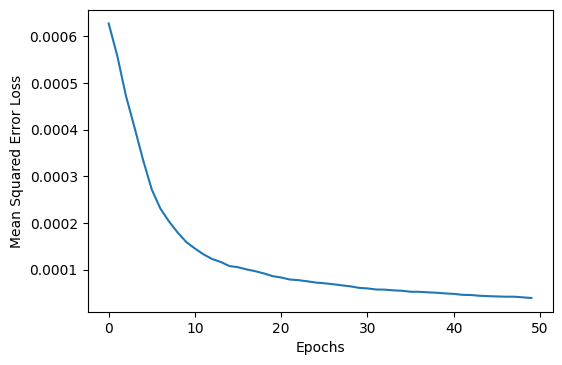

In [40]:
# Autoencoder Running
clustering_pipeline.run_autoencoder_pipeline(n_clusters, size, optimizer)

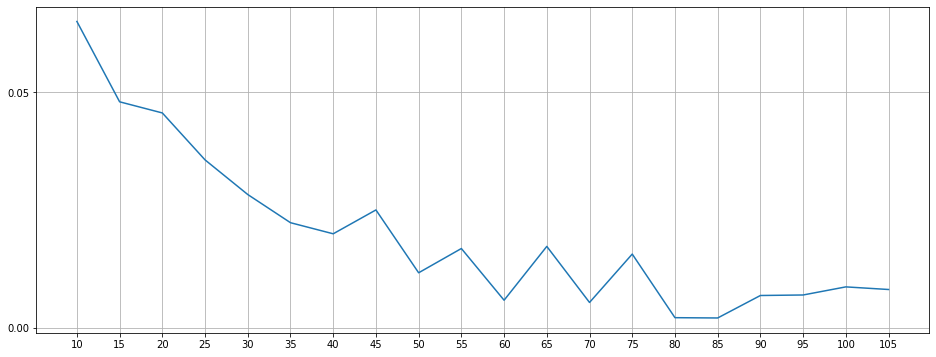

In [41]:
# Choosing optinmal K- Values
possible_k_values = [x for x in range(10,110,5)]
clustering_pipeline.plot_elbow(possible_k_values)

The above graph shows the best choices of K are 15, 20 as suggested by the silhouette score. Beyond that the score tends to worsen for more clusters. For the purpose of this experiment, I am choosing to go ahead with K=20. 

In [42]:
new_pred = clustering_pipeline.run_cluster_pipeline(n_clusters)
new_data = data.copy()
new_data['cluster'] = new_pred
new_data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,cluster
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,7
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,11
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",18
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",14
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,3


In [43]:
# Cluster Distribution
new_data.cluster.value_counts()

18    853
7     824
3     575
16    451
15    402
10    381
11    374
0     361
6     347
12    340
13    340
1     334
8     314
5     299
4     272
17    271
9     267
19    265
14    260
2     257
Name: cluster, dtype: int64

In [44]:
# T-SNE for Visualization
from sklearn.manifold import TSNE

x_embedded = TSNE(n_components=2).fit_transform(seq_data)

x_embedded.shape

(7787, 2)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


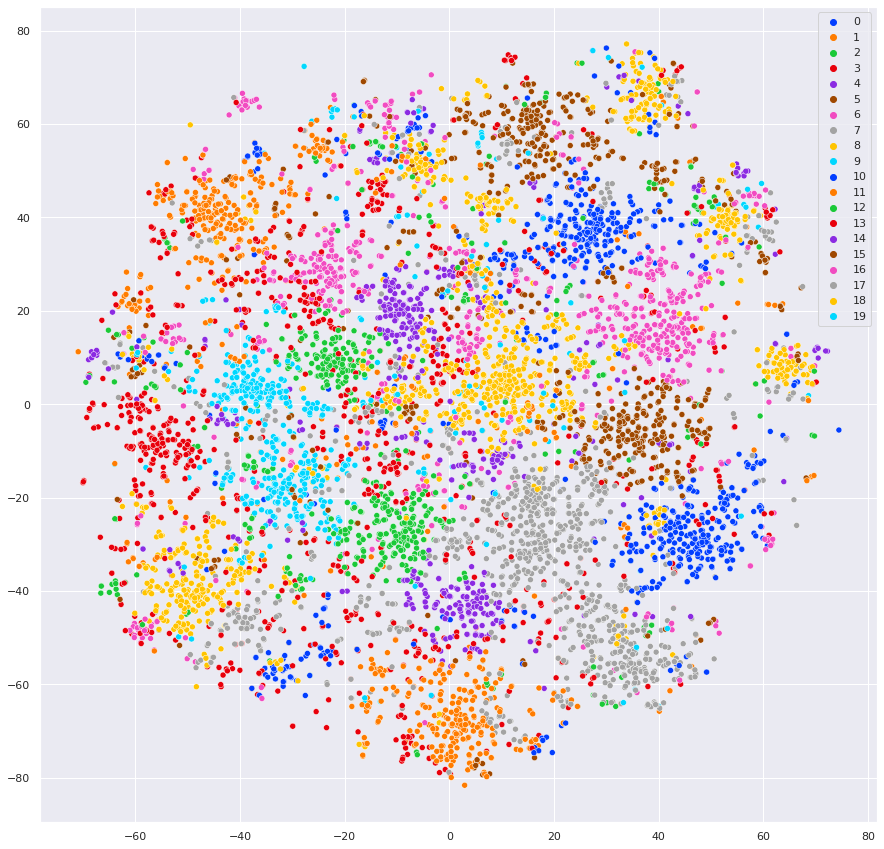

In [45]:
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})


# colors
palette = sns.color_palette("bright", len(set(new_pred)))

# plot
sns.scatterplot(x_embedded[:,0], x_embedded[:,1], hue=new_pred, legend='full', palette=palette)
plt.savefig('output2.png')
plt.show()

In [46]:
new_data.to_csv('/kaggle/working/classified_data.csv')